# 手把手來刻 tensoeflow model

In [1]:
import time
import os
import numpy as np
import tensorflow as tf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import pandas as pd

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 使用第一張 GPU

預設本來就會使用第一張gpu (編號為0)，之後做專題時可以開多個 gpu，如果要同時 train 多個模型必須指定要用第幾張，否則所有程式都會執行第一張，導致後面執行的程式拿不到 gpu 無法執行。

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# 讀入資料

可以用 index_col = 0, 讓 id 變成 index，在取用時就不用用 .iloc[:, :1] 來避開 id

In [3]:
df_train = pd.read_csv('data/train.csv', index_col=0)

In [4]:
df_train.head(n=3)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
Id,,,,,,,,,,,,,,,,,,,,,
832ff325-90ce-40e3-8c74-42b679b99e5c,2941,32,4,108,12,3369,219,230,147,2574,...,0,0,0,0,0,0,0,0,0,2
6ea6b99e-c247-40d9-87fe-345aab8e87a4,2304,20,19,350,141,1423,203,195,124,939,...,0,0,0,0,0,0,0,0,0,3
d28eb06b-19e6-4951-8845-3c7f1484393e,3397,157,13,458,46,2255,234,241,136,474,...,0,0,0,0,0,0,1,0,0,7


# 轉成 numpy array
1. 用 .iloc 分開 x 和 y
2. 用 .value 得到 numpy array

In [5]:
train_x = df_train.iloc[:, :54].values
train_x[0]

array([2941,   32,    4,  108,   12, 3369,  219,  230,  147, 2574,    1,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    1,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0])

* 用 [:, :54] 會得到 series 取 value 會得到 1 維正列
* 用 [:, :54:] 會得到 dataframe，取 value 會得到 2 維正列要在 reshape 才能得到我們預期的 y

In [6]:
train_y = df_train.iloc[:, 54].values
train_y[0]

2

* 用 [:, 54:]

In [7]:
print(df_train.iloc[:, 54:].values)

[[2]
 [3]
 [7]
 ...
 [6]
 [2]
 [5]]


# 1. prepocessing

## minmax scaler

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_x = train_x.astype(np.float32)
train_x = scaler.fit_transform(train_x)

### 如果要用 numpy 做的話
1. 減掉 min 讓最小值為 0
2. 除以 range 讓大家在 1~0 之間 (加上 10^-10 是為了避免除以 0)

In [11]:
train_x = (train_x - train_x.min(axis=0)) / (train_x.max(axis=0) - train_x.min(axis=0) + 1e-10)

### 加 axis=0 的差別 （因為知道沒有 0 故不加上小數）
不加 axis=0 則會除以整個 matrix 最大的 range
range 在 1~3 的第一個參數雖然在 0~1 之間，但是可以發現他變得超小。
本來未了讓所有變數的 range 都差不多的目的還是沒有達成

In [12]:
x = np.array([[1, 11001], [2, 2005], [3, 3000]])
x = (x - x.min()) / (x.max() - x.min())
print(x.max(axis=0))
print(x.min(axis=0))

[1.81818182e-04 1.00000000e+00]
[0.         0.18218182]


## one-hot encoding

In [13]:
train_y

array([2, 3, 7, ..., 6, 2, 5])

In [14]:
class_num = int(len(np.unique(train_y))) # 有幾個 class
train_y -= train_y.min() # 讓 label 為 0~(class_num-1) 的整數
train_y = np.eye(class_num)[(train_y)] # eye 會產生對角線矩陣，取出第幾列則為該類別的one-hot

### 以三類為例

In [15]:
np.eye(3) # 產生 3 * 3 對角線矩陣

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [16]:
np.eye(3)[0] # label 為 0 得到的 one-hot (取出 row 0)

array([1., 0., 0.])

## train val split

In [17]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.2, random_state=94)

# build model

In [18]:
epoch = 5
batch_size = 64
lr = 1e-2

## build input layer

In [19]:
tf.reset_default_graph() 

with tf.name_scope('input'):
    x_input = tf.placeholder(shape=(None,) +  x_train.shape[1:], 
                             name='x_input',
                             dtype=tf.float32)
    y_out = tf.placeholder(shape=(None, class_num), 
                           name='y_label',
                           dtype=tf.float32)

## build hidden layer

In [20]:
with tf.variable_scope('hidden_layer'):
    x_h1 = tf.layers.dense(inputs=x_input, units=128, activation=tf.nn.relu, name='hidden1')
    x_h2 = tf.layers.dense(inputs=x_h1, units=256, activation=tf.nn.relu, name='hidden2')
    x_h3 = tf.layers.dense(inputs=x_h2, units=512, activation=tf.nn.relu, name='hidden3')

print(x_h2)

Tensor("hidden_layer/hidden2/Relu:0", shape=(?, 256), dtype=float32)


## build output layer

In [21]:
with tf.variable_scope('output_layer'):
    output = tf.layers.dense(x_h3, class_num, name='output')

## build loss function

In [22]:
with tf.name_scope('cross_entropy'):
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits_v2(
            logits=output, labels=y_out), name='loss')

## predict class
過 softmax 不影響相互的大小關係，故不再計算 loss 的狀況下，可以直接用 argmax 判斷 label

In [23]:
with tf.name_scope('predict'):
    y_pred_cls = tf.argmax(output, axis=1)

### argmax 實例

In [24]:
y = [[0.5, 0.4, 0.2], [0.4, 0.5, 0.2]]
argmax = tf.argmax(y, axis=1)
sess = tf.Session()
sess.run(argmax)

array([0, 1])

## compute accurary

In [25]:
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(y_pred_cls, tf.argmax(y_out, axis=1))
    compute_acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### accuracy 詳細步驟
2筆資料的 pred 結果為 1, 2，label 為 [0, 1, 0], [1, 0, 0]  
用 constant 宣告 pred_y, true_y 是為了不用 intial variable

In [26]:
pred_y = tf.constant([1, 2], dtype=tf.int64)
true_y = tf.constant([[0, 1, 0], [1, 0, 0]], dtype=tf.int64)

In [66]:
argmax_true_y = tf.argmax(true_y, axis=1)
print('argmax 結果', tf.Session().run(argmax_true_y))

argmax 結果 [1 0]


In [67]:
correct = tf.equal(pred_y, argmax_true_y)
print('correct 結果', tf.Session().run(correct))

correct 結果 [ True False]


In [68]:
cast = tf.cast(correct, tf.float32) # 相當於 np.astype(np.float32)
print('cast 結果', tf.Session().run(cast))

cast 結果 [1. 0.]


In [69]:
acc = tf.reduce_mean(cast) # 相當於 np.mean()
print('acc 結果', tf.Session().run(acc))

acc 結果 0.5


## build optimizer

In [27]:
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)

# 2. train your model

In [29]:
from sklearn.utils import shuffle

train_loss_epoch, train_acc_epoch = [], []
test_loss_epoch, test_acc_epoch = [], []

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in tqdm_notebook(range(epoch)):
    
    print("\nEpoch: {0}/{1}\n".format((i+1), epoch))

    train_loss_batch = []
    train_acc_batch = []
    
    # 計算有幾個 batch
    total_batch = int(np.ceil(len(x_train) / batch_size))
        
    x_train, y_train = shuffle(x_train, y_train)
    
    for j in range(total_batch):
        start_time = time.time()

        # 執行 update
        X_batch = x_train[j * batch_size: min(len(x_train), (j + 1) * batch_size)]
        y_batch = y_train[j * batch_size: (j + 1) * batch_size]
        batch_loss, batch_acc, _ = sess.run([loss, compute_acc, train_step], 
                                            feed_dict={x_input: X_batch, y_out: y_batch})
        
        # 計算 batch 所花的時間
        duration = time.time() - start_time
        
        # 印出結果，每個 epoch 印三次
        if j % (total_batch // 3) == 0:
            # 計算要印幾個 >
            percentage = int(round((j/total_batch)*100))
            bar_len = 29
            filled_len = int((bar_len*int(percentage))/100)
            bar = '=' * filled_len + '>' + '-' * (bar_len - filled_len)

            print(f"step: {j:>5} - [{bar}] {percentage:>3}% - acc: {batch_acc:.4f}%",
                  f" - loss: {batch_loss:.4f} - {(batch_size / duration):.1f} sample/sec")

        
        train_loss_batch.append(batch_loss)
        train_acc_batch.append(batch_acc)
        
    train_loss_epoch.append(np.mean(train_loss_batch))
    train_acc_epoch.append(np.mean(train_acc_batch))


Epoch: 1/5

step:     0 - [>-----------------------------]   0% - acc: 0.1406%  - loss: 1.9496 - 325.7 sample/sec
step:    60 - [=========>--------------------]  33% - acc: 0.6406%  - loss: 0.7223 - 63146.4 sample/sec
step:   120 - [===================>----------]  67% - acc: 0.6094%  - loss: 0.9290 - 56751.7 sample/sec

Epoch: 2/5

step:     0 - [>-----------------------------]   0% - acc: 0.6719%  - loss: 0.8306 - 55924.1 sample/sec
step:    60 - [=========>--------------------]  33% - acc: 0.7656%  - loss: 0.5851 - 56500.8 sample/sec
step:   120 - [===================>----------]  67% - acc: 0.6094%  - loss: 0.8267 - 61766.1 sample/sec

Epoch: 3/5

step:     0 - [>-----------------------------]   0% - acc: 0.6719%  - loss: 0.7282 - 63265.5 sample/sec
step:    60 - [=========>--------------------]  33% - acc: 0.6719%  - loss: 0.7120 - 60855.9 sample/sec
step:   120 - [===================>----------]  67% - acc: 0.7656%  - loss: 0.5778 - 62137.8 sample/sec

Epoch: 4/5

step:     0 - 

# 3. visualize training preocess

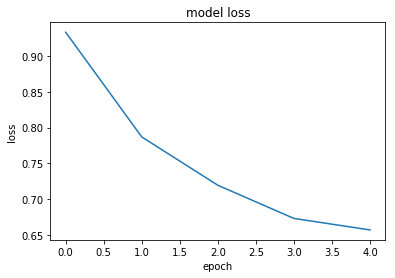

In [37]:
plt.plot(train_loss_epoch)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

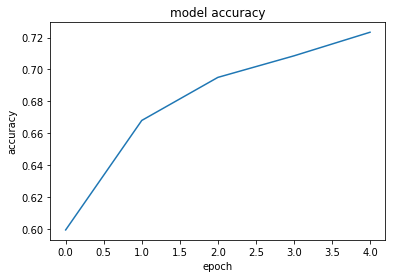

In [38]:
plt.plot(train_acc_epoch)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# 4. batch prediction

In [31]:
def predict(x, batch_size=32):
    i = 0
    predicted_class = np.zeros(shape=len(x), dtype=np.int)
    while i < len(x):
        j = i + batch_size
        batch_xs = x[i: j]
        # 計算 predict 結果
        predicted_class[i:j] = sess.run(
            y_pred_cls,
            feed_dict={x_input: batch_xs}
        )
        i += j
    return predicted_class

predict(x_val)

array([2, 6, 0, ..., 0, 0, 0])

# 5. compute accuracy

計算每次的loss再取平均，小心如果使用 f1-score 不能用 batch 算 (大家可以分成兩的 batch 手算看看)。

In [32]:
def compute_loss_and_accuracy(x, y, batch_size=32):
    i = 0
    losses = []
    accuracy = []
    while i < len(x):
        j = i + batch_size
        batch_xs = x[i: i + batch_size, :]
        batch_ys = y[i: i + batch_size, :]
        l, acc = sess.run(
            [loss, compute_acc],
            feed_dict={x_input: batch_xs, y_out: batch_ys}
        )
        losses.append(l)
        accuracy.append(acc)
        i += batch_size    
    return np.mean(losses), np.mean(accuracy)

compute_loss_and_accuracy(x_val, y_val)

(0.6808236, 0.7056111)

# 6. callbacks

### declare variable

In [33]:
global_accuracy = 0 # 存checkpoint用，為當前最高的acc
global_non_progress = 0 # early start 用，為目前有幾個epoch沒有進步
saver = tf.train.Saver()
save_path = './checkpoint/checkpoint.ckpt'

### create checkpoint dir
建立 check point 資料夾 避免 saver 報錯

In [44]:
directory = os.path.dirname(save_path)
print(directory)
if not os.path.exists(directory):
    os.makedirs(directory)

./checkpoint


## checkpoint

In [38]:
def test_and_save(epoch):
    global global_accuracy
    l, acc = compute_loss_and_accuracy(x_val, y_val)
    
    
    mes = "\nEpoch {} - loss: {:2f} accuracy: {:.2f}%"
    print(mes.format((epoch+1), l, acc))

    # 如果 acc 比較大，則存 model 並將 global_accuracy 設為此時的 acc
    if global_accuracy < acc:

        saver.save(sess, save_path=save_path, global_step=epoch)

        print(f"This epoch receive better accuracy: {acc:.2f}% > {global_accuracy:.2f}%.",
              f" Saving session...")
        
        global_accuracy = acc

    return l, acc
test_and_save(0)


Epoch 1 - loss: 0.680824 accuracy: 0.71%


(0.6808236, 0.7056111)

## early stop

In [40]:
def early_stop(val_acc, steps=50):
    global global_accuracy
    global global_non_progress

    # 如果 global_accuracy 比較大，沒進步epoch數 + 1
    if global_accuracy > val_acc:
        global_non_progress += 1
    
    # 如果 acc 比較大，重新計算沒進步epoch數
    else:
        global_non_progress = 0
    
    # 如果沒進步epoch數大於 steps 回傳 true 代表需要停止
    if global_non_progress > steps:
        print(f"Didn't receive better accuracy after {global_non_progress:2d}",
              " epochs. Stop traing...")
        return True

    return False

## weight decay

### step decay
將 Optimizer 的 lr 用 placeholder 取代直接給一個數值, 讓在執行 sess.run 時，可以決定當前的 learing rate  
此處以不同當前 epoch 數決定 lr 為例子

In [41]:
learning_rate_t = tf.placeholder(tf.float32, shape=[], name='learning_rate')
with tf.name_scope('train_with_sd'):
    train_step_with_sd = tf.train.AdamOptimizer(learning_rate=learning_rate_t).minimize(loss)

def lr_decay(epoch):
    learning_rate = 1e-2
    if epoch > 400:
        learning_rate *= 1e-3
    elif epoch > 200:
        learning_rate *= 1e-2
    elif epoch > 100:
        learning_rate *= 1e-1
    return learning_rate

### exponential decay

$$ decayed\_learning\_rate = learning\_rate *
                        decay\_rate ^{ (global\_step \; / \; decay\_steps)} $$

由 tensorflow 控制的 lr  
https://www.tensorflow.org/api_docs/python/tf/train/exponential_decay

In [42]:
learning_rate_decay = tf.train.exponential_decay(1e-2, epoch, 100, 0.96, staircase=True)
with tf.name_scope('train_with_ed'):
    train_step_with_ed = tf.train.AdamOptimizer(learning_rate=learning_rate_decay).minimize(loss)

# 7. train again

In [43]:
train_loss_epoch, train_acc_epoch = [], []
test_loss_epoch, test_acc_epoch = [], []

use_step_decay = True
use_exponential_decay = True

sess = tf.Session()
sess.run(tf.global_variables_initializer())

epoch=500 #調高 epoch 看 early stop 的運作

for i in tqdm_notebook(range(epoch)):
    
    print("\nEpoch: {0}/{1}\n".format((i+1), epoch))

    train_loss_batch = []
    train_acc_batch = []
    
    total_batch = int(np.ceil(len(x_train) / batch_size))
        
    x_train, y_train = shuffle(x_train, y_train)
    
    for j in range(total_batch):
        start_time = time.time()

        X_batch = x_train[j * batch_size: (j + 1) * batch_size]
        y_batch = y_train[j * batch_size: (j + 1) * batch_size]
        
        if use_step_decay:
            # 用自己控制的 lr
            batch_loss, batch_acc, _ = sess.run([loss, compute_acc, train_step_with_sd], 
                                                 feed_dict={x_input: X_batch, y_out: y_batch, learning_rate_t:lr_decay(i)})
        elif use_exponential_decay:
            # 用 tf 控制的 lr
            batch_loss, batch_acc, _ = sess.run([loss, compute_acc, train_step_with_ed], 
                                                 feed_dict={x_input: X_batch, y_out: y_batch})
        else:
            # 用固定的 lr
            batch_loss, batch_acc, _ = sess.run([loss, compute_acc, train_step], 
                                                 feed_dict={x_input: X_batch, y_out: y_batch})
        
        duration = time.time() - start_time
        
        if j % (total_batch // 3) == 0:
            percentage = int(round((j/total_batch)*100))
            bar_len = 29
            filled_len = int((bar_len*int(percentage))/100)
            bar = '=' * filled_len + '>' + '-' * (bar_len - filled_len)

            print(f"step: {j:>5} - [{bar}] {percentage:>3}% - acc: {batch_acc:.4f}%",
                  f" - loss: {batch_loss:.4f} - {(batch_size / duration):.1f} sample/sec")

        train_loss_batch.append(batch_loss)
        train_acc_batch.append(batch_acc)    
        
    train_loss_epoch.append(np.mean(train_loss_batch))
    train_acc_epoch.append(np.mean(train_acc_batch))
    
    # 每個 epoch 計算 val acc 並判斷是否要存檔
    val_loss, val_acc = test_and_save(i)

    test_loss_epoch.append(val_loss)
    test_acc_epoch.append(val_acc)
    
    # 每個 epoch 確認是否停止訓練
    if early_stop(val_acc):
        break



Epoch: 1/5

step:     0 - [>-----------------------------]   0% - acc: 0.2188%  - loss: 1.9459 - 1362.4 sample/sec
step:    60 - [=========>--------------------]  33% - acc: 0.5469%  - loss: 0.9486 - 54560.1 sample/sec
step:   120 - [===================>----------]  67% - acc: 0.6719%  - loss: 0.9395 - 58725.8 sample/sec

Epoch 1 - loss: 0.808876 accuracy: 0.66%

Epoch: 2/5

step:     0 - [>-----------------------------]   0% - acc: 0.6094%  - loss: 0.8802 - 54962.2 sample/sec
step:    60 - [=========>--------------------]  33% - acc: 0.6719%  - loss: 0.8021 - 64188.3 sample/sec
step:   120 - [===================>----------]  67% - acc: 0.6562%  - loss: 0.9245 - 51286.9 sample/sec

Epoch 2 - loss: 0.740570 accuracy: 0.69%

Epoch: 3/5

step:     0 - [>-----------------------------]   0% - acc: 0.7031%  - loss: 0.7394 - 60938.8 sample/sec
step:    60 - [=========>--------------------]  33% - acc: 0.7031%  - loss: 0.6663 - 56382.2 sample/sec
step:   120 - [===================>----------]

# 8. visualize learnig process

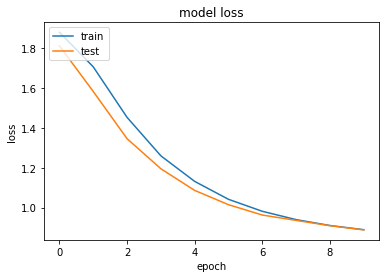

In [56]:
plt.plot(train_loss_epoch)
plt.plot(test_loss_epoch)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

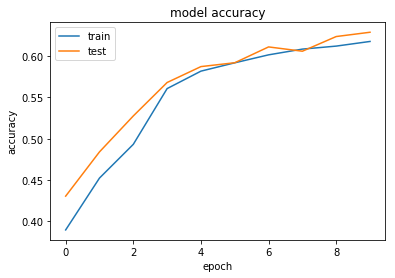

In [57]:
plt.plot(train_acc_epoch)
plt.plot(test_acc_epoch)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 9. predict test data

不用 idx_col=0 因為寫 csv 需要 id

In [52]:
df_test = pd.read_csv('data/test.csv')
test_x = scaler.transform(df_test.iloc[:, 1:].values)
result = predict(test_x) + 1

### 寫 csv 檔

In [53]:
with open('result.csv', 'w') as f:
    f.write('id,class\n')
    
    for i, r in df_test.iterrows():
        f.write('%s,%d\n' % (r[0], result[i]))